<a href="https://colab.research.google.com/github/Antares01/semester_project_ml_for_finance/blob/main/semester_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO:
add test options in and out of money
add log price as second input
try equally spaced distribution

In [103]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
!pip install tf-quant-finance
import tf_quant_finance as tff 

option_price = tff.black_scholes.option_price


In [104]:
import numpy as np
import torch
from torch import nn
from scipy.stats import lognorm
from matplotlib import pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
from tqdm import tqdm

In [132]:
# option price generation parameters
TOT_OPTIONS = 100
EXPIRY = 1.0
RATE = 0.0
SPOT = 100
STRIKE_MIN = 50
STRIKE_MAX = 150
VOLATILITY = 5

LAMBDA = SPOT / 3 # scaling factor for spot and strike
SPOT_SCALED = SPOT/LAMBDA
STRIKE_MIN_SCALED = STRIKE_MIN/LAMBDA
STRIKE_MAX_SCALED = STRIKE_MAX/LAMBDA
SCALED_VOLATILITY = VOLATILITY/LAMBDA

# NN parameters
MC_STEPS_STARTING = 2**8
MC_STEPS_FINAL = 2**12

EPOCHS = 300
batch_size = 16


#distribution parameters
PROPOSAL_SIGMA = SCALED_VOLATILITY #0.3/10 * 4 sigma should not be divided 
PROPOSAL_MU_SCALED = np.log(SPOT_SCALED) - 0.5 * PROPOSAL_SIGMA**2 
PROPOSAL_MU = np.log(SPOT) - 0.5 * VOLATILITY**2

#integration parameter
INTERVAL_LENGTH = 10
START_UNIF = 0

In [106]:
"""
# Calculate discount factors (e^-rT)
rate = 0.05
expiries = np.array([0.5, 1.0, 2.0, 1.3])
discount_factors = np.exp(-rate * expiries)
# Current value of assets.
spots = np.array([0.9, 1.0, 1.1, 0.9])
# Forward value of assets at expiry.
forwards = spots / discount_factors
# Strike prices given by:
strikes = np.array([1.0, 2.0, 1.0, 0.5])
# Indicate whether options are call (True) or put (False)
is_call_options = np.array([True, True, False, False])
# The volatilites at which the options are to be priced.
volatilities = np.array([0.7, 1.1, 2.0, 0.5])
# Calculate the prices given the volatilities and term structure.
prices = option_price(
      volatilities=volatilities,
      strikes=strikes,
      expiries=expiries,
      forwards=forwards,
      discount_factors=discount_factors,
      is_call_options=is_call_options)
prices
"""

'\n# Calculate discount factors (e^-rT)\nrate = 0.05\nexpiries = np.array([0.5, 1.0, 2.0, 1.3])\ndiscount_factors = np.exp(-rate * expiries)\n# Current value of assets.\nspots = np.array([0.9, 1.0, 1.1, 0.9])\n# Forward value of assets at expiry.\nforwards = spots / discount_factors\n# Strike prices given by:\nstrikes = np.array([1.0, 2.0, 1.0, 0.5])\n# Indicate whether options are call (True) or put (False)\nis_call_options = np.array([True, True, False, False])\n# The volatilites at which the options are to be priced.\nvolatilities = np.array([0.7, 1.1, 2.0, 0.5])\n# Calculate the prices given the volatilities and term structure.\nprices = option_price(\n      volatilities=volatilities,\n      strikes=strikes,\n      expiries=expiries,\n      forwards=forwards,\n      discount_factors=discount_factors,\n      is_call_options=is_call_options)\nprices\n'

In [133]:
rates = np.array([RATE]*TOT_OPTIONS)
discount_factors = np.exp(- (rates)*EXPIRY)
spots = np.array([SPOT]*TOT_OPTIONS)
forwards = spots / discount_factors
strikes = np.linspace(STRIKE_MIN, STRIKE_MAX, TOT_OPTIONS) #[50., 60. , 75., 110., 125., 135. ]  #
is_call_options = np.random.choice(a=[False, True], size=(TOT_OPTIONS,)) #[True, True, True, False, False, False] #
volatilities = np.array([VOLATILITY]*TOT_OPTIONS)
expiries = np.array([EXPIRY]*TOT_OPTIONS)
prices = option_price(
      volatilities=volatilities,
      strikes=strikes,
      expiries=expiries,
      forwards=forwards,
      discount_factors=discount_factors,
      is_call_options=is_call_options)

In [156]:
prices = option_price(
      volatilities=10,
      strikes=50.0,
      expiries=1.,
      spots=100,
      discount_factors=1,
      is_call_options=True)
prices

<tf.Tensor: shape=(), dtype=float32, numpy=99.99996>

In [146]:
prices

<tf.Tensor: shape=(), dtype=float32, numpy=99.99996>

In [108]:
scaled_prices = np.array(prices/LAMBDA)

In [135]:
print(strikes)
print(is_call_options)

[ 50.          51.01010101  52.02020202  53.03030303  54.04040404
  55.05050505  56.06060606  57.07070707  58.08080808  59.09090909
  60.1010101   61.11111111  62.12121212  63.13131313  64.14141414
  65.15151515  66.16161616  67.17171717  68.18181818  69.19191919
  70.2020202   71.21212121  72.22222222  73.23232323  74.24242424
  75.25252525  76.26262626  77.27272727  78.28282828  79.29292929
  80.3030303   81.31313131  82.32323232  83.33333333  84.34343434
  85.35353535  86.36363636  87.37373737  88.38383838  89.39393939
  90.4040404   91.41414141  92.42424242  93.43434343  94.44444444
  95.45454545  96.46464646  97.47474747  98.48484848  99.49494949
 100.50505051 101.51515152 102.52525253 103.53535354 104.54545455
 105.55555556 106.56565657 107.57575758 108.58585859 109.5959596
 110.60606061 111.61616162 112.62626263 113.63636364 114.64646465
 115.65656566 116.66666667 117.67676768 118.68686869 119.6969697
 120.70707071 121.71717172 122.72727273 123.73737374 124.74747475
 125.7575757

In [130]:
scaled_prices

array([3.        , 3.        , 1.56060606, 1.59090909, 1.62121212,
       1.65151515, 3.        , 3.        , 3.        , 3.        ,
       3.        , 3.        , 3.        , 1.89393939, 3.        ,
       3.        , 1.98484848, 2.01515152, 3.        , 2.07575758,
       3.        , 3.        , 2.16666667, 3.        , 3.        ,
       3.        , 3.        , 2.31818182, 2.34848485, 3.        ,
       2.40909091, 2.43939394, 3.        , 2.5       , 2.53030303,
       3.        , 3.        , 3.        , 3.        , 2.68181818,
       3.        , 2.74242424, 3.        , 3.        , 3.        ,
       2.86363636, 2.89393939, 2.92424242, 2.95454545, 3.        ,
       3.        , 3.        , 3.07575758, 3.        , 3.13636364,
       3.        , 3.1969697 , 3.        , 3.        , 3.28787879,
       3.31818182, 3.34848485, 3.        , 3.        , 3.        ,
       3.46969697, 3.5       , 3.        , 3.56060606, 3.        ,
       3.62121212, 3.        , 3.        , 3.        , 3.74242

In [110]:
#scaled version
"""
spots_scaled = np.array([SPOT_SCALED]*TOT_OPTIONS)
forwards_scaled = spots_scaled / discount_factors
strikes_scaled = strikes/LAMBDA #[50., 60. , 75., 110., 125., 135. ]  #
prices_scaled = option_price(
      volatilities=volatilities,
      strikes=strikes_scaled,
      expiries=expiries,
      forwards=forwards_scaled,
      discount_factors=discount_factors,
      is_call_options=is_call_options)
      """

'\nspots_scaled = np.array([SPOT_SCALED]*TOT_OPTIONS)\nforwards_scaled = spots_scaled / discount_factors\nstrikes_scaled = strikes/LAMBDA #[50., 60. , 75., 110., 125., 135. ]  #\nprices_scaled = option_price(\n      volatilities=volatilities,\n      strikes=strikes_scaled,\n      expiries=expiries,\n      forwards=forwards_scaled,\n      discount_factors=discount_factors,\n      is_call_options=is_call_options)\n      '

In [111]:
#tf.math.logical_and( (prices_scaled * LAMBDA >= prices - 0.01), (prices_scaled * LAMBDA <= prices + 0.01))   

In [112]:
#print(prices)
#print(prices_scaled * LAMBDA)

In [113]:
# Jakob suggestion
"""
START_UNIF=0
INTERVAL_LENGTH=20
MC_STEPS=20000
coordinates=np.linspace(start=START_UNIF+INTERVAL_LENGTH/(2*MC_STEPS),stop=START_UNIF+INTERVAL_LENGTH-INTERVAL_LENGTH/(2*MC_STEPS),num=MC_STEPS)+np.random.uniform(low=-INTERVAL_LENGTH/(2*MC_STEPS),high=INTERVAL_LENGTH/(2*MC_STEPS),size=MC_STEPS)
coordinates = np.linspace(start = START_UNIF, stop = START_UNIF+INTERVAL_LENGTH, num=MC_STEPS / 2) + np.random(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH)
print(coordinates)
"""

'\nSTART_UNIF=0\nINTERVAL_LENGTH=20\nMC_STEPS=20000\ncoordinates=np.linspace(start=START_UNIF+INTERVAL_LENGTH/(2*MC_STEPS),stop=START_UNIF+INTERVAL_LENGTH-INTERVAL_LENGTH/(2*MC_STEPS),num=MC_STEPS)+np.random.uniform(low=-INTERVAL_LENGTH/(2*MC_STEPS),high=INTERVAL_LENGTH/(2*MC_STEPS),size=MC_STEPS)\ncoordinates = np.linspace(start = START_UNIF, stop = START_UNIF+INTERVAL_LENGTH, num=MC_STEPS / 2) + np.random(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH)\nprint(coordinates)\n'

In [114]:
from torch.utils.data import DataLoader
scaled_strikes = strikes / LAMBDA
prices_and_strikes = [ (scaled_prices[i], scaled_strikes[i], is_call_options[i]) for i in range(TOT_OPTIONS)]
target_dataloader = DataLoader(prices_and_strikes , batch_size=batch_size, shuffle = True)
#test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [115]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 128),
            nn.LeakyReLU(1e-1),
            
            nn.Linear(128, 512),
            nn.LeakyReLU(1e-1),   

            nn.Linear(512, 128),
            nn.LeakyReLU(1e-1),
            
            nn.Linear(128, 1)
        )
        self.softplus = nn.Softplus()
        
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = self.softplus(x)
        return x


class LognormalNet(nn.Module):
  def __init__(self):
    super(LognormalNet, self).__init__()
    self.sigma = nn.Parameter(torch.Tensor([PROPOSAL_SIGMA]))
    self.mu = nn.Parameter(torch.Tensor([PROPOSAL_MU]))

  def forward(self, x):
    return 1/(x * self.sigma * np.sqrt(2* np.pi)) * torch.exp(-(torch.log(x) - self.mu)**2 / (2* self.sigma**2) )

In [116]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = BaselineNet().to(device)
print(model)

Using cpu device
BaselineNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (softplus): Softplus(beta=1, threshold=20)
)


In [117]:
class OptionLoss(nn.Module):
    def __init__(self, beta):
        super(OptionLoss,self).__init__()
        self.beta = beta
    
    # outputs the MC_STEPS predictions, labels the TOT_OPTIONS labels
    def forward(self, outputs, labels, strike, is_call, coordinates):
        loss = 0
        mc_integral = 0
        payoff = lambda  j :  torch.max(torch.zeros(MC_STEPS), coordinates - strike[j] ) if is_call[j] else torch.max(torch.zeros(MC_STEPS), strike[j] - coordinates)
        #densities_ratio = torch.div(outputs , torch.Tensor([lognorm.pdf(coordinates, PROPOSAL_SIGMA, 0, np.exp(PROPOSAL_MU)) ]))
        #print(outputs)
        densities = 1/INTERVAL_LENGTH #torch.Tensor([lognorm.pdf(coordinates, PROPOSAL_SIGMA, 0, np.exp(PROPOSAL_MU)) ])
        #print(densities_ratio)
        for j in range(len(labels)):
          numerator  = payoff(j)
          mc_price = numerator * outputs / densities
          #print(coordinates)
          #print(strikes[j])
          #print(numerator)
          #print(mc_price)
          #plt.scatter(coordinates,payoff(j))
          #plt.xlim(-1,20)
          #plt.ylim(-1,20)
          #print(payoff(j))
          #print(mc_price)
          #print(mc_price.sum() / MC_STEPS)
          loss += (labels[j] -  mc_price.sum() / MC_STEPS)**2
          #loss += (labels[j] - mc_price.sum() / MC_STEPS)**2

        
        """
        for i in range(MC_STEPS - 1):
          mc_integral += (coordinates[i+1] - coordinates[i])*(outputs[i+1] - outputs[i])
        """
        #print("custom loss is " + str(loss))
        #print("mc integral " + str(mc_integral))
        #print("integral loss is " + str(self.beta * (1 - 0.5*mc_integral)**2))
        return loss  #+ self.beta * (1 - 0.5*mc_integral)**2
            

In [118]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-20)
loss_fn = OptionLoss(0)

In [119]:
loss_history = []
for epoch in tqdm(range(EPOCHS)):
    for batch, (target_prices, strike_prices, is_call) in enumerate(target_dataloader):
        if epoch < EPOCHS * 0.8:
          MC_STEPS = MC_STEPS_STARTING
        else:
          MC_STEPS = MC_STEPS_FINAL
        #x = np.concatenate( [ np.linspace(start = START_UNIF, stop = START_UNIF+INTERVAL_LENGTH, num=MC_STEPS // 2) , np.random.uniform(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH, size=MC_STEPS//2) ] ) 
        x = np.concatenate([ np.random.uniform(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH/10, size=MC_STEPS//4) , np.random.uniform(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH, size=MC_STEPS//2) , np.random.uniform(low = START_UNIF + 9*INTERVAL_LENGTH/10 , high= START_UNIF+INTERVAL_LENGTH, size=MC_STEPS//4) ])
        x = np.expand_dims(x, axis = 1)
        X = torch.Tensor(x) #coordinates are not sorted
        #X = torch.zeros(MC_STEPS, 1).to(device)
        #X.uniform_(0, INTERVAL_LENGTH)
        #X.log_normal_(PROPOSAL_MU, PROPOSAL_SIGMA )
        #print(X)
        pred = model(X)
        loss = loss_fn(pred.cpu().squeeze(), target_prices, strike_prices, is_call, X.cpu().squeeze())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-1)
        optimizer.step()
    loss_history.append(float(loss))


100%|██████████| 300/300 [01:06<00:00,  4.52it/s]


In [120]:
np.expand_dims(x, axis = 1)

array([[[0.72448918]],

       [[0.24299108]],

       [[0.75016341]],

       ...,

       [[9.38250209]],

       [[9.28129593]],

       [[9.62279148]]])

In [121]:
# EXPERIMENT 
i = 0
X = torch.zeros(MC_STEPS)
X.log_normal_(PROPOSAL_MU, PROPOSAL_SIGMA)
X = np.array(X)
#prices[i], strikes[i], is_call_options[i]
#payoff =   np.maximum(np.zeros(MC_STEPS), X - strikes[i] ) if is_call_options[i] else np.maximum(np.zeros(MC_STEPS), strikes[i] - X)
#print( ( prices[i] - (payoff.sum() / MC_STEPS))**2 )

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


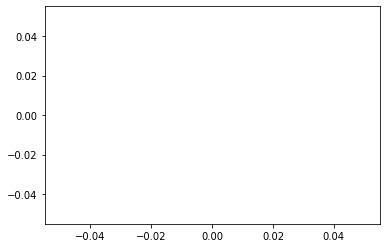

In [122]:
x = np.linspace(0, 20, num = 10000)
y = lognorm.pdf(x, SCALED_VOLATILITY, 0, np.exp(PROPOSAL_MU))
plt.plot(x, y)

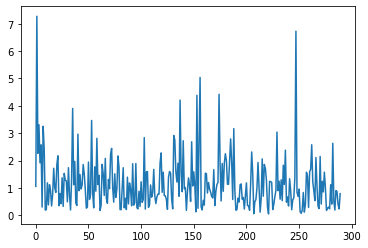

In [123]:
plt.plot(range(len(loss_history[-290:])), loss_history[-290:])
#plt.ylim(bottom=-0.0001,top=100)

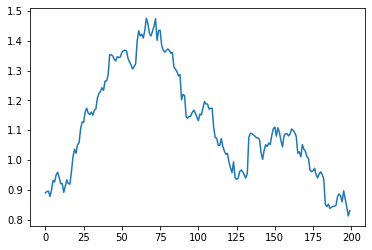

In [124]:
running_loss_average = uniform_filter1d(loss_history[-200:], size=50)
plt.plot(range(len(running_loss_average)), running_loss_average)

In [125]:
loss_history

[152.6985086567115,
 16.90975784413683,
 11.124526153730915,
 8.888629681438612,
 8.623438347954338,
 5.021276089083312,
 3.2250305273702535,
 3.1949272960939967,
 0.058162279987084384,
 2.6051698573266577,
 1.0572318490653916,
 7.271452894509096,
 2.263973276644265,
 3.306500164898182,
 1.9161329635596671,
 2.5743527594262092,
 0.3012981890536129,
 3.252863951666365,
 2.4060315069719582,
 0.19108492582860975,
 0.20755676627325556,
 1.1862511345750641,
 0.3819758108042309,
 1.119945444968876,
 0.9100053015526667,
 0.34252957803948697,
 0.7646947724578067,
 1.7197322134410342,
 1.0089413062237895,
 0.835795621942566,
 1.85451036534435,
 2.174061592827066,
 0.3524171950971049,
 0.7962334109768485,
 0.4231165734420606,
 1.371232480279591,
 0.32575069141413987,
 1.5330622466448671,
 1.2796462667669946,
 1.257960932089275,
 0.49204491801445766,
 1.7395237508872883,
 0.7381535823353013,
 0.19640193344264695,
 1.3279962435670933,
 3.904419679775458,
 1.11574845286311,
 1.970607138345441,
 0.4

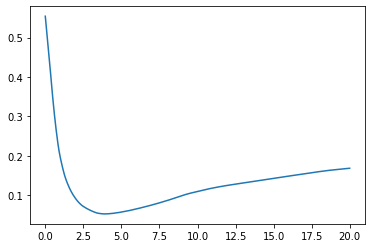

In [126]:
x = torch.Tensor(np.arange(0, 20, 0.01)).to(device).unsqueeze(-1)
p = model(x)
plt.plot(x.cpu().detach().numpy(), p.cpu().detach().numpy())

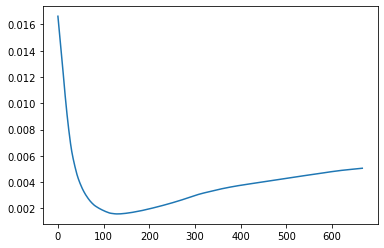

In [127]:
x = torch.Tensor(np.arange(0, 20 , 0.01)).to(device).unsqueeze(-1)
p = model(x) 
plt.plot(x.cpu().detach().numpy() * LAMBDA, p.cpu().detach().numpy() / LAMBDA)

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


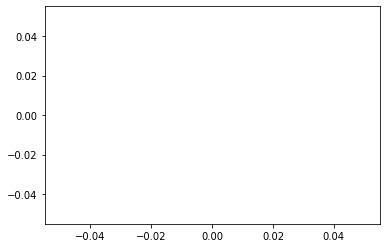

In [128]:
x = np.linspace(0.0001, 20 * LAMBDA, num = 10000)
y = lognorm.pdf(x , s=VOLATILITY, loc=0, scale=np.exp(PROPOSAL_MU))
plt.plot(x, y)

In [129]:
for para in model.parameters():
    print(para)

Parameter containing:
tensor([[-0.3030],
        [-0.1798],
        [ 0.5819],
        [ 0.2316],
        [-0.1800],
        [-0.5222],
        [-0.2866],
        [-0.5507],
        [-0.4675],
        [-0.1076],
        [ 0.0544],
        [ 0.8814],
        [-0.4594],
        [ 0.1310],
        [-0.3233],
        [ 0.7971],
        [-0.7323],
        [ 0.8864],
        [ 0.6744],
        [ 0.4476],
        [ 0.0787],
        [ 0.1303],
        [ 0.1456],
        [-0.6853],
        [ 0.5828],
        [-0.1604],
        [-0.0387],
        [ 0.7153],
        [ 0.6937],
        [ 0.8763],
        [ 0.0823],
        [-0.0793],
        [ 0.7070],
        [-0.5868],
        [-0.5757],
        [-0.7911],
        [ 0.5992],
        [ 0.4225],
        [ 0.7791],
        [ 0.9635],
        [ 0.8563],
        [-0.1205],
        [ 0.8378],
        [ 0.7385],
        [ 0.1775],
        [-0.8126],
        [-0.8659],
        [ 0.3356],
        [ 0.2873],
        [ 0.1838],
        [ 0.4514],
        [